In [5]:

import pandas as pd
import numpy as np
import dfhealth as dh 
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
import matplotlib.pyplot as plt 
import seaborn as sns 
import mlflow 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
import joblib  # Model persistence
import pickle

# API + Deployment
from fastapi import FastAPI
from fastapi.middleware.cors import CORSMiddleware
from pydantic import BaseModel
import uvicorn

# Docker + Containerization
import docker
from docker import client


In [6]:
#LOAD PANDAS DATA FRAME 
df = pd.read_csv('Fraud Detection Dataset.csv')

In [7]:
df.head() # First 5 rows


,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Time_of_Transaction,Device_Used,Location,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Payment_Method,Fraudulent
0,T1,4174,1292.76,ATM Withdrawal,16.0,Tablet,San Francisco,0,119,13,Debit Card,0
1,T2,4507,1554.58,ATM Withdrawal,13.0,Mobile,New York,4,79,3,Credit Card,0
2,T3,1860,2395.02,ATM Withdrawal,NaN,Mobile,NaN,3,115,9,NaN,0
3,T4,2294,100.10,Bill Payment,15.0,Desktop,Chicago,4,3,4,UPI,0
4,T5,2130,1490.50,POS Payment,19.0,Mobile,San Francisco,2,57,7,Credit Card,0


In [8]:
#mlflow autologging
mlflow.autolog()

2026/01/22 14:34:00 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2026/01/22 14:34:01 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2026/01/22 14:34:01 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


In [9]:
# investigate data frame for issues using health check 
report = dh.health_check(df)
report.print()

🏥 Data Health Report: 4 issues found

Summary:
  - WARN: 3
  - INFO: 1

--- WARNS ---
• D001 (Duplicate Rows): 881 duplicate rows detected
  └─ Suggested Fix: Use df.drop_duplicates() to remove redundant rows
• I001 (ID Integrity): Column 'Transaction_ID' looks like an ID but contains non-unique values
  └─ Column: Transaction_ID
  └─ Suggested Fix: Check if duplicates in ID column are intentional; IDs should usually be unique
• I001 (ID Integrity): Column 'User_ID' looks like an ID but contains non-unique values
  └─ Column: User_ID
  └─ Suggested Fix: Check if duplicates in ID column are intentional; IDs should usually be unique

--- INFOS ---
• O001 (Extreme Outliers): Column 'Transaction_Amount' has 508 extreme outliers
  └─ Column: Transaction_Amount
  └─ Suggested Fix: Consider investigating values outside of [3*IQR] range

📖 Code Reference:
  D001: Duplicate Rows
  I001: ID Integrity
  O001: Extreme Outliers


In [10]:
# lets drop the duplicated rows 
df.drop_duplicates(inplace=True)

In [11]:
#lets review data types 
df.dtypes

Transaction_ID                       object
User_ID                               int64
Transaction_Amount                  float64
Transaction_Type                     object
Time_of_Transaction                 float64
Device_Used                          object
Location                             object
Previous_Fraudulent_Transactions      int64
Account_Age                           int64
Number_of_Transactions_Last_24H       int64
Payment_Method                       object
Fraudulent                            int64
dtype: object

# lets investigate  transaction amount column 


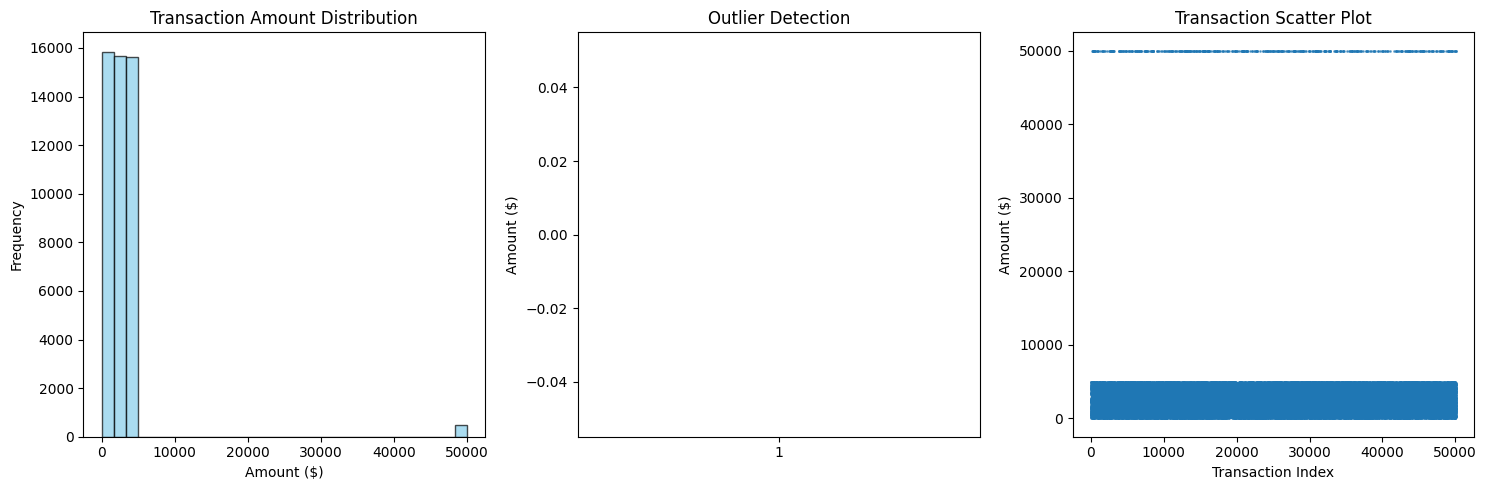

Transaction Amount Summary:
Average: $2999.10
Median: $2523.58
Min: $5.03
Max: $49997.80
Standard Deviation: $5061.21


In [12]:
# Simple but detailed transaction amount analysis
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Distribution histogram
axes[0].hist(df['Transaction_Amount'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_title('Transaction Amount Distribution')
axes[0].set_xlabel('Amount ($)')
axes[0].set_ylabel('Frequency')

# 2. Box plot for outliers
axes[1].boxplot(df['Transaction_Amount'])
axes[1].set_title('Outlier Detection')
axes[1].set_ylabel('Amount ($)')

# 3. Your original scatter plot (improved)
axes[2].scatter(range(len(df['Transaction_Amount'])), df['Transaction_Amount'], alpha=0.6, s=1)
axes[2].set_title('Transaction Scatter Plot')
axes[2].set_xlabel('Transaction Index')
axes[2].set_ylabel('Amount ($)')

plt.tight_layout()
plt.show()

# Key statistics
print("Transaction Amount Summary:")
print(f"Average: ${df['Transaction_Amount'].mean():.2f}")
print(f"Median: ${df['Transaction_Amount'].median():.2f}")
print(f"Min: ${df['Transaction_Amount'].min():.2f}")
print(f"Max: ${df['Transaction_Amount'].max():.2f}")
print(f"Standard Deviation: ${df['Transaction_Amount'].std():.2f}")

In [13]:
#checkinf null values
df.isnull().sum()

Transaction_ID                         0
User_ID                                0
Transaction_Amount                  2476
Transaction_Type                       0
Time_of_Transaction                 2505
Device_Used                         2437
Location                            2500
Previous_Fraudulent_Transactions       0
Account_Age                            0
Number_of_Transactions_Last_24H        0
Payment_Method                      2428
Fraudulent                             0
dtype: int64

In [14]:
#dropping null values
df.dropna(inplace=True)

In [15]:
df.isnull().sum()

Transaction_ID                      0
User_ID                             0
Transaction_Amount                  0
Transaction_Type                    0
Time_of_Transaction                 0
Device_Used                         0
Location                            0
Previous_Fraudulent_Transactions    0
Account_Age                         0
Number_of_Transactions_Last_24H     0
Payment_Method                      0
Fraudulent                          0
dtype: int64

In [16]:
#shape of the dataframe
df.shape

(38895, 12)

# Feature Engineering

In [17]:

df['Time_of_Transaction'] = pd.to_datetime(df['Time_of_Transaction'])  # Assume string format
df['hour'] = df['Time_of_Transaction'].dt.hour
df['day_of_week'] = df['Time_of_Transaction'].dt.dayofweek
df['Account_Age'] = pd.to_numeric(df['Account_Age'], errors='coerce')  # Ensure numeric

df.head()

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Time_of_Transaction,Device_Used,Location,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Payment_Method,Fraudulent,hour,day_of_week
0,T1,4174,1292.76,ATM Withdrawal,1970-01-01 00:00:00.000000016,Tablet,San Francisco,0,119,13,Debit Card,0,0,3
1,T2,4507,1554.58,ATM Withdrawal,1970-01-01 00:00:00.000000013,Mobile,New York,4,79,3,Credit Card,0,0,3
3,T4,2294,100.10,Bill Payment,1970-01-01 00:00:00.000000015,Desktop,Chicago,4,3,4,UPI,0,0,3
4,T5,2130,1490.50,POS Payment,1970-01-01 00:00:00.000000019,Mobile,San Francisco,2,57,7,Credit Card,0,0,3
5,T6,2095,2372.04,ATM Withdrawal,1970-01-01 00:00:00.000000015,Desktop,Boston,3,96,14,Credit Card,0,0,3


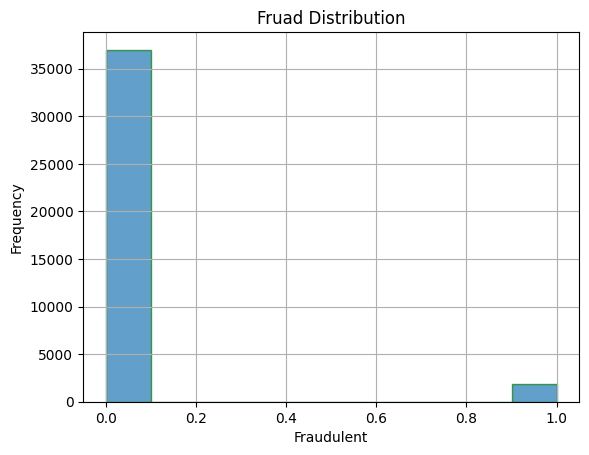

In [18]:
# plotting a histogram to show distribution fro our target value
df['Fraudulent'].hist(bins=10, edgecolor='green', alpha=0.7)
plt.xlabel('Fraudulent')
plt.ylabel('Frequency')
plt.title('Fruad Distribution')
plt.show()


In [19]:
# Defining categorical, numerical columns and target.
cat_col = ['Transaction_Type', 'Device_Used', 'Location', 'Payment_Method']
num_col = ['Previous_Fraudulent_Transaction', 'Number_of_transactions_Last_24h',
            'Account_Age', 'hour', 'day_of_week']

x = df.drop('Fraudulent', axis=1)
y = df['Fraudulent']



In [20]:
#Spliting data into trainng and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.2, random_state=33, stratify=y)

In [21]:
# confirming  categorical and numerical features/ columns 
# TRUE numeric columns only (int/float)
num_features = x_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# ALL string/object columns  
cat_features = x_train.select_dtypes(include=['object']).columns.tolist()

print("Numeric features:", num_features)
print("Categorical features:", cat_features)

Numeric features: ['User_ID', 'Transaction_Amount', 'Previous_Fraudulent_Transactions', 'Account_Age', 'Number_of_Transactions_Last_24H']
Categorical features: ['Transaction_ID', 'Transaction_Type', 'Device_Used', 'Location', 'Payment_Method']


# Creating preprocessing pipeline

In [22]:
preprocess = ColumnTransformer([
    ('num', StandardScaler(), num_features), ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features)
]
    
)

# Full Pipeline

In [23]:
full_pipe = Pipeline([
    ('prepo', preprocess), ('rfc', RandomForestClassifier(n_estimators=150, class_weight='balanced',
                                                                                             random_state=33))
  ]
)

In [24]:
#Train model 
full_pipe.fit(x_train, y_train)

2026/01/22 14:34:05 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '779b2eec3d4a469994e5852a8425a82d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Pipeline(steps=[('prepo',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['User_ID',
                                                   'Transaction_Amount',
                                                   'Previous_Fraudulent_Transactions',
                                                   'Account_Age',
                                                   'Number_of_Transactions_Last_24H']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Transaction_ID',
                                                   'Transaction_Type',
                                                   'Device_Used', 'Location',
                                                   'Payment_Method'])])),
                ('rfc',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=150, random_state=33))])

In [25]:
#train a lightGBM model 
LightGBM_full_pipe = Pipeline([
    ('prepo', preprocess), ('LGBM', LGBMClassifier(n_estimators=150, class_weight='balanced',num_leaves=31,
                                                                                             random_state=33))
  ]
)
LightGBM_full_pipe.fit(x_train, y_train)

2026/01/22 14:34:40 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '746c66ff8ca94b159b8709fa3facd0f3', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


[LightGBM] [Info] Number of positive: 380, number of negative: 7399
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 687
[LightGBM] [Info] Number of data points in the train set: 7779, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


Pipeline(steps=[('prepo',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['User_ID',
                                                   'Transaction_Amount',
                                                   'Previous_Fraudulent_Transactions',
                                                   'Account_Age',
                                                   'Number_of_Transactions_Last_24H']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Transaction_ID',
                                                   'Transaction_Type',
                                                   'Device_Used', 'Location',
                                                   'Payment_Method'])])),
                ('LGBM',
                 LGBMClassifier(class_weight='balanced', n_estimators=150,
                                random_state=33))])

In [26]:
#Prediction
results = full_pipe.predict(x_test)
print(f'{classification_report(y_test, results)}') #classification Report

y_pred_proba = full_pipe.predict_proba(x_test)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test ROC-AUC: {test_roc_auc:.3f}")

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     29597
           1       0.00      0.00      0.00      1519

    accuracy                           0.95     31116
   macro avg       0.48      0.50      0.49     31116
weighted avg       0.90      0.95      0.93     31116

Test ROC-AUC: 0.508


In [27]:
#save model 
r_model = joblib.dump(full_pipe, 'model_fraud.pickle')

Total features after preprocessing: 7797
Top 5 Most Important Features:
                                 feature  importance
1                num__Transaction_Amount    0.079515
0                           num__User_ID    0.078953
3                       num__Account_Age    0.075568
4   num__Number_of_Transactions_Last_24H    0.058865
2  num__Previous_Fraudulent_Transactions    0.042314


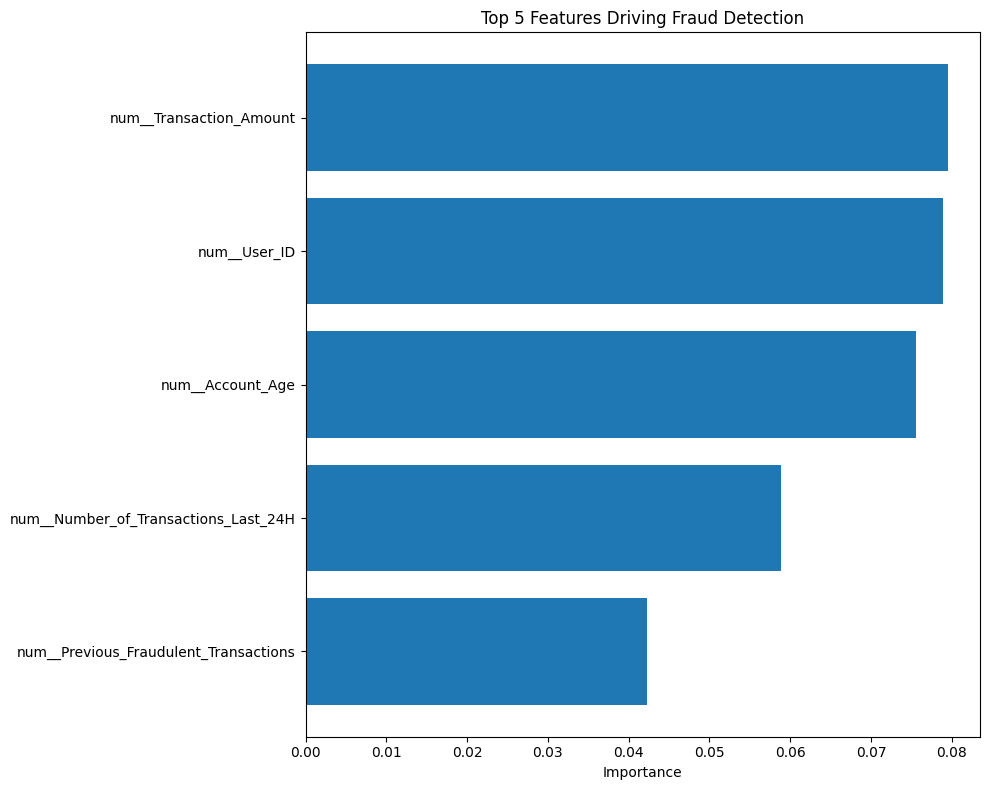

In [28]:
#feature importance from our model

# Get trained Random Forest from pipeline
rf = full_pipe.named_steps['rfc']

# Get feature importances
importances = rf.feature_importances_

# Get feature names (after preprocessing)
feature_names = full_pipe.named_steps['prepo'].get_feature_names_out()
print("Total features after preprocessing:", len(feature_names))

# Combine importances with feature names
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("Top 5 Most Important Features:")
print(feature_importance_df.head(5))

# Plot top 5 features
top_features = feature_importance_df.head(5)
plt.figure(figsize=(10, 8))
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 5 Features Driving Fraud Detection')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()





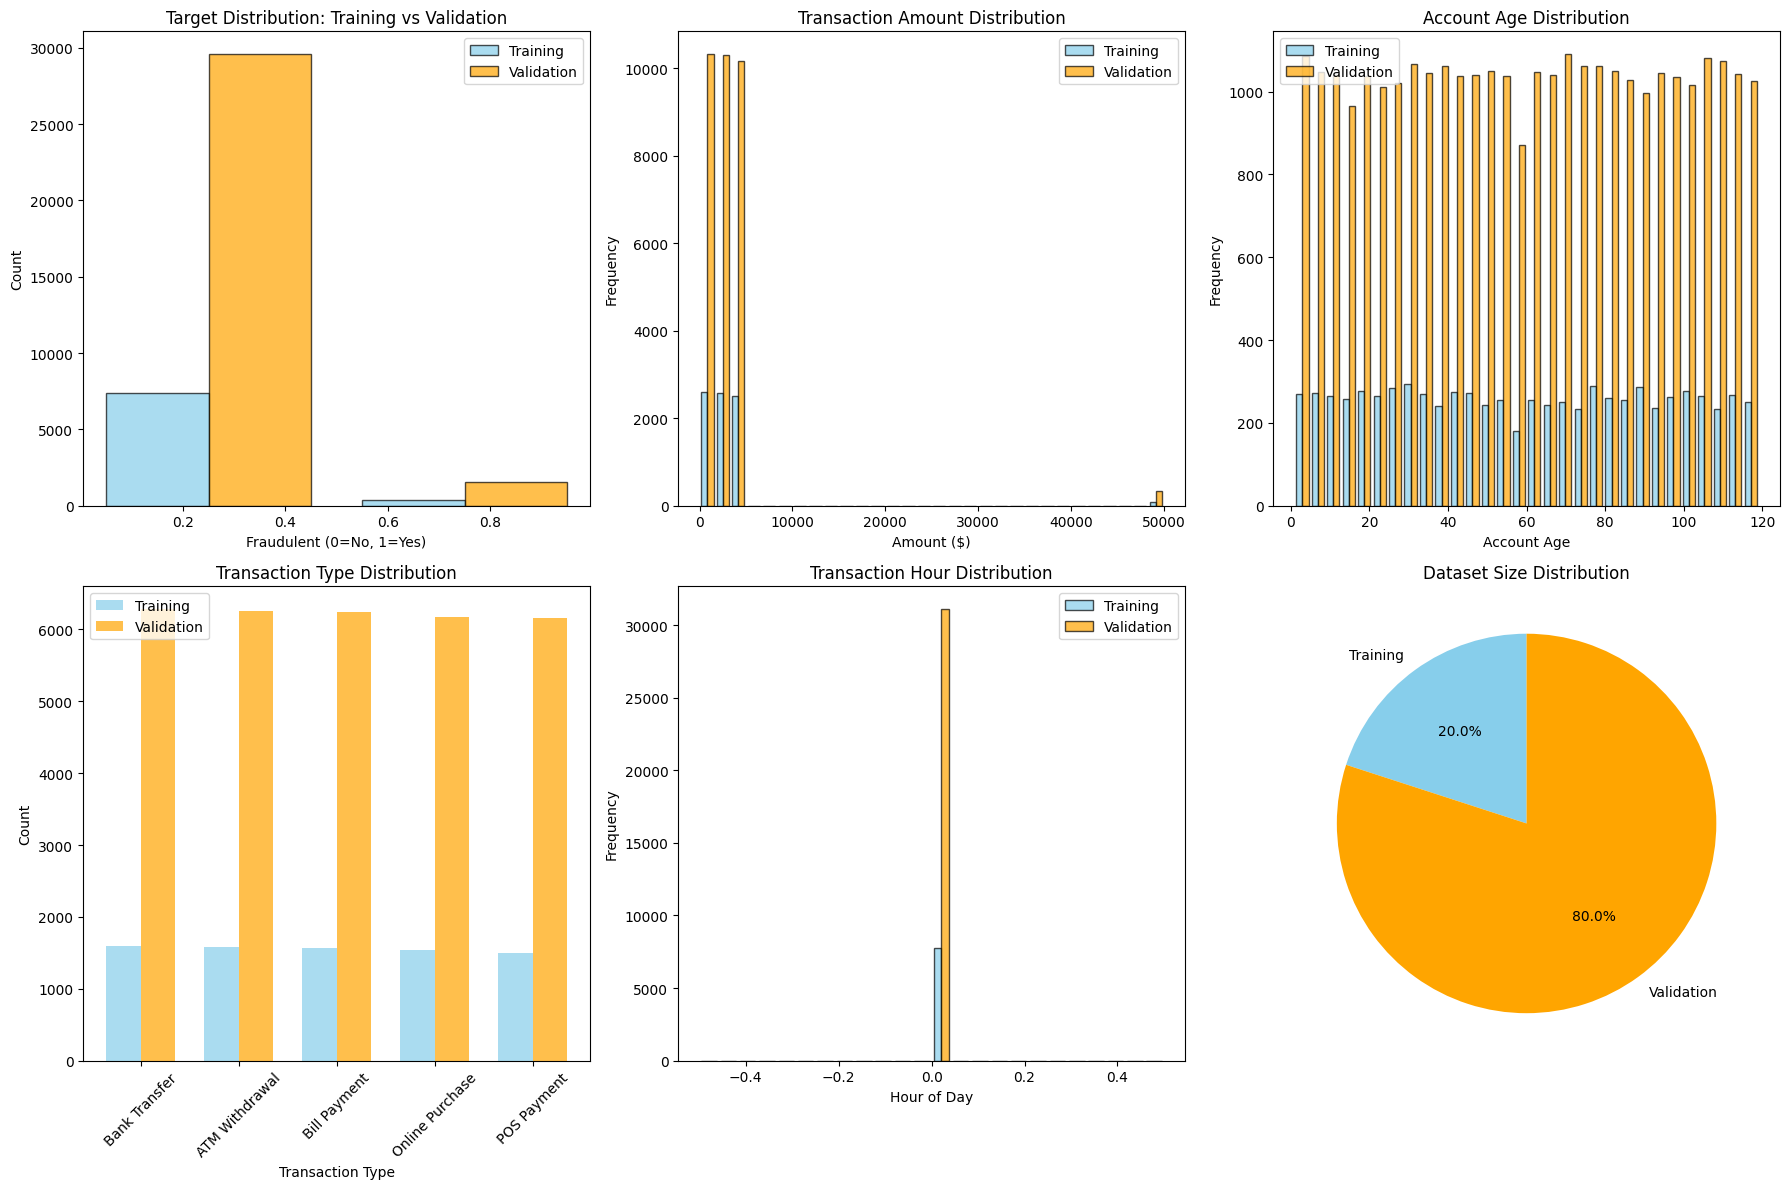

Dataset Summary:
Training set size: 7,779 samples
Validation set size: 31,116 samples
Training fraud rate: 0.049
Validation fraud rate: 0.049


In [32]:
# Visual comparison between training and validation data
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Target distribution comparison
axes[0, 0].hist([y_train, y_test], bins=2, alpha=0.7, label=['Training', 'Validation'], 
                color=['skyblue', 'orange'], edgecolor='black')
axes[0, 0].set_title('Target Distribution: Training vs Validation')
axes[0, 0].set_xlabel('Fraudulent (0=No, 1=Yes)')
axes[0, 0].set_ylabel('Count')
axes[0, 0].legend()

# 2. Transaction amount distribution
axes[0, 1].hist([x_train['Transaction_Amount'], x_test['Transaction_Amount']], 
                bins=30, alpha=0.7, label=['Training', 'Validation'], 
                color=['skyblue', 'orange'], edgecolor='black')
axes[0, 1].set_title('Transaction Amount Distribution')
axes[0, 1].set_xlabel('Amount ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# 3. Account age distribution
axes[0, 2].hist([x_train['Account_Age'], x_test['Account_Age']], 
                bins=30, alpha=0.7, label=['Training', 'Validation'], 
                color=['skyblue', 'orange'], edgecolor='black')
axes[0, 2].set_title('Account Age Distribution')
axes[0, 2].set_xlabel('Account Age')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].legend()

# 4. Transaction type comparison
train_tx_type = x_train['Transaction_Type'].value_counts()
test_tx_type = x_test['Transaction_Type'].value_counts()

width = 0.35
x_pos = range(len(train_tx_type))
axes[1, 0].bar([p - width/2 for p in x_pos], train_tx_type.values, width, 
               label='Training', color='skyblue', alpha=0.7)
axes[1, 0].bar([p + width/2 for p in x_pos], test_tx_type.values, width, 
               label='Validation', color='orange', alpha=0.7)
axes[1, 0].set_title('Transaction Type Distribution')
axes[1, 0].set_xlabel('Transaction Type')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(train_tx_type.index, rotation=45)
axes[1, 0].legend()

# 5. Hour of transaction distribution
axes[1, 1].hist([x_train['hour'], x_test['hour']], 
                bins=24, alpha=0.7, label=['Training', 'Validation'], 
                color=['skyblue', 'orange'], edgecolor='black')
axes[1, 1].set_title('Transaction Hour Distribution')
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

# 6. Data size comparison
data_sizes = [len(x_train), len(x_test)]
labels = ['Training', 'Validation']
colors = ['skyblue', 'orange']
axes[1, 2].pie(data_sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axes[1, 2].set_title('Dataset Size Distribution')

plt.tight_layout()
plt.show()

# Print summary statistics
print("Dataset Summary:")
print(f"Training set size: {len(x_train):,} samples")
print(f"Validation set size: {len(x_test):,} samples")
print(f"Training fraud rate: {y_train.mean():.3f}")
print(f"Validation fraud rate: {y_test.mean():.3f}")

In [31]:
#tracking model artifacts using mmlflow ui

import subprocess
import threading
import time

def start_mlflow_ui():
    """Start MLflow UI in a separate process"""
    try:
        # Start MLflow UI on default port 5000
        process = subprocess.Popen(['mlflow', 'ui'], 
                                 stdout=subprocess.PIPE, 
                                 stderr=subprocess.PIPE)
        print("MLflow UI starting...")
        time.sleep(3)  # Give it time to start
        print("MLflow UI should be available at: http://localhost:5000")
        print("Note: The UI will run in the background. Close this notebook to stop it.")
        return process
    except Exception as e:
        print(f"Error starting MLflow UI: {e}")
        print("Try running 'mlflow ui' in your terminal instead")

# Start MLflow UI
mlflow_process = start_mlflow_ui()

MLflow UI starting...
MLflow UI should be available at: http://localhost:5000
Note: The UI will run in the background. Close this notebook to stop it.


In [ ]:
#mlflow ready to track, monitor , save to model rgistry and deploy endpoint....